# Homework 2 Solutions

These will take a little bit of time, maybe 30-60 seconds, to re-run as configured.  There are a couple of moderately expensive steps with stochastic explorations of minima and searches around minima.

In [1]:
import numpy as np
from scipy import optimize
from scipy import interpolate
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font',**{'family':'serif','serif':['Palatino'],'size': 18})
rc('text', usetex=True)
rc('lines', **{'linewidth':3.0})
rc('axes', **{'labelsize':22})

### Part 1a

We first use linear least squares to fit the model

$T[\nu] \approx a_0 \nu^{-2.5} + a_1 \nu^{-2.5} \log \nu + a_2 \nu^{-2.5} \left( \log \nu \right)^2 + a_3 \nu^{-4.5} + a_4 \nu^{-2}$

to the sky brightness temperature.  We will construct the matrix of coefficients and fit using `np.linalg.lstsq`.

Text(0, 0.5, '${\\rm Residual}~T_{\\rm sky}~({\\rm K})$')

C:\Users\Rohit Penumarti\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


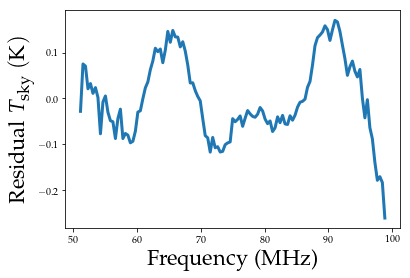

In [2]:
nu, T = np.loadtxt('skytemperature.dat').T
nu /= 75

# Define the matrix of coefficients
A = np.ones((len(nu), 5))
A[:, 0] = 1/nu**2.5
A[:, 1] = np.log(nu)/nu**2.5
A[:, 2] = np.log(nu)**2/nu**2.5
A[:, 3] = 1/nu**4.5
A[:, 4] = 1/nu**2

# Compute the best-fit coefficients
a_best = np.linalg.lstsq(A, T, rcond=None)[0]

# Compute the best-fit model
T_fit_lin = np.dot(A, a_best)

# Plot the residuals!
plt.plot(nu*75, T - T_fit_lin)
plt.xlabel("Frequency (MHz)")
plt.ylabel(r"${\rm Residual}~T_{\rm sky}~({\rm K})$")

### Part 1b

Now we fit the model 

$T[\nu] = b_0 \nu^{-2.5 + b_1 + b_2 \log \nu} e^{-b_3 \nu^{-2}} + b_4 \nu^{-2}$

using nonlinear least squares.  I'll use `curve_fit` here, returning all of the optional information so that I can print out the number of function evaluations.

C:\Users\Rohit Penumarti\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in multiply
  


curve_fit required 765 function evaluations.
Standard deviation of the linear fit: 87.6 mK
Standard deviation of the nonlinear fit: 84.3 mK


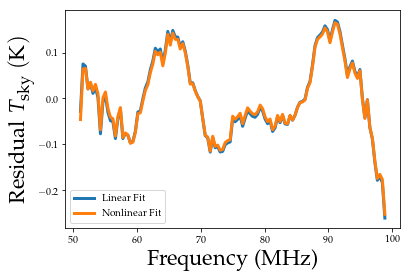

In [3]:
def Tmodel_nonlin(nu, b0, b1, b2, b3, b4):
    return b0*nu**(-2.5 + b1 + b2*np.log(nu))*np.exp(-b3/nu**2) + b4/nu**2

# We'll use curve_fit here.  It works without complaining.
# full_output returns a bunch of extra stuff, including information on how many times
# the function to be optimized was evaluated.

bfit, cov, info, convergence, success = optimize.curve_fit(Tmodel_nonlin, nu, T, full_output=1)

print("curve_fit required %d function evaluations." % (info['nfev']))

T_fit_nonlin = Tmodel_nonlin(nu, *bfit)

# Plot both residuals on the same axes for comparison.
plt.plot(nu*75, T - T_fit_lin)
plt.plot(nu*75, T - T_fit_nonlin)
plt.legend(['Linear Fit', 'Nonlinear Fit'])
plt.xlabel("Frequency (MHz)")
plt.ylabel(r"${\rm Residual}~T_{\rm sky}~({\rm K})$")

print("Standard deviation of the linear fit: %.1f mK" % (1000*np.std(T - T_fit_lin)))
print("Standard deviation of the nonlinear fit: %.1f mK" % (1000*np.std(T - T_fit_nonlin)))

### Part 1c

Now we fit the model 

$T[\nu] = b_0 \nu^{-2.5 + b_1 + b_2 \log \nu} e^{-b_3 \nu^{-2}} + b_4 \nu^{-2}$

as in part (b), but we linearize things.  First, I'll subtract the $b_4 \nu^{-2}$ and then take the log of both sides (using $\log$ as shorthand for the natural logarithm):

$\log \left( T[\nu] - b_4 \nu^{-2} \right) = \log b_0 + \left(-2.5 + b_1 + b_2 \log \nu \right) \log \nu -b_3 \nu^{-2}$

I'll then move the $2.5 \log \nu$ to the left-hand-side:

$\log \left( T[\nu] - b_4 \nu^{-2} \right) + 2.5 \log \nu = b_0^\prime + b_1 \log \nu + b_2 \left(\log \nu \right)^2 - b_3 \nu^{-2}$

This is now linear in $b_1$, $b_2$, $b_3$, and $b_0^\prime \equiv \log b_0$.

We'll use $\left(\frac{d\log \left( T[\nu] - b_4 \nu^{-2} \right)}{dT}\right)^2 = \frac{1}{\left( T[\nu] - b_4 \nu^{-2} \right)^2}$ as the variance to keep the weights the same as before.

Linearized optimization took 30 evaluations of a more difficult function.
Standard deviation of the linear fit: 87.6 mK
Standard deviation of the nonlinear fit: 84.3 mK


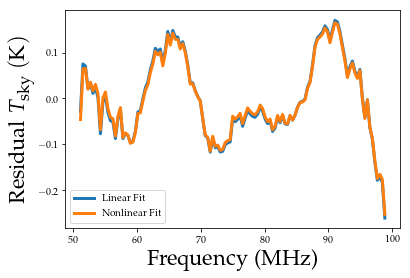

In [4]:
# We'll first define a class to hold some stuff relevant to the linear models.  
# This will be useful later.  I won't end up using all of these attributes.

class Linmodel:
    def __init__(self):
        self.par = None
        self.y = None
        self.cov = None
        self.cov_inv = None
        
# This function will return a Linmodel object, defined above.

def Tmodel_linearized(b4, nu, T):  
    
    result = Linmodel()
    
    # Don't take the log of a negative number.  
    # Return infinity so that a minimization routine stays far away.
        
    if np.any(T - b4/nu**2 < 0):
        result.y = np.inf
        return result
    
    lefthandside = np.log(T - b4/nu**2) + 2.5*np.log(nu)
    A = np.ones((len(nu), 4))
    A[:, 0] = 1
    A[:, 1] = 1./nu**2
    A[:, 2] = np.log(nu)
    A[:, 3] = np.log(nu)**2
    
    # Variance to equate the weights with the approach from earlier
    
    var = 1/(T - b4/nu**2)**2
    
    # Solve the linear system
    
    b = lefthandside/np.sqrt(var)
    Ap = A/np.sqrt(var[:, np.newaxis])
    bfit = np.linalg.lstsq(Ap, b, rcond=None)[0]
    
    # Transform back to sky temperature
    
    righthandside = np.dot(A, bfit)

    result.y = np.exp(righthandside - 2.5*np.log(nu)) + b4/nu**2
    return result

# This is a reasonably flexible function to return the chi squared value
# of a fitted model.  I use an optional dictionary to pass keywords to 
# the function to be fit.  This will make it easier to change details later,
# like when we fit different exponents or a nondiagonal covariance matrix.

def chisq_model(par, model, nu, T, kwargs={}):
    if not 'Cdata_inv' in kwargs:
        return np.sum((model(par, nu, T, **kwargs).y - T)**2)
    else:
        Cdata_inv = kwargs['Cdata_inv']
        model_args = kwargs.copy()
        del model_args['Cdata_inv']
        resid = model(par, nu, T, **model_args).y - T
        return np.linalg.multi_dot([resid, Cdata_inv, resid])
    
# Now I can use scalar minimization, since I'm down to one variable

result = optimize.minimize_scalar(chisq_model, args=(Tmodel_linearized, nu, T))
b4 = result.x
print("Linearized optimization took %d evaluations of a more difficult function." % (result.nfev))

# Compute the residual for plotting.
T_fit = Tmodel_linearized(b4, nu, T).y

plt.plot(nu*75, T - T_fit_lin)
plt.plot(nu*75, T - T_fit)
plt.legend(['Linear Fit', 'Nonlinear Fit'])
plt.xlabel("Frequency (MHz)")
plt.ylabel(r"${\rm Residual}~T_{\rm sky}~({\rm K})$")

print("Standard deviation of the linear fit: %.1f mK" % (1000*np.std(T - T_fit_lin)))
print("Standard deviation of the nonlinear fit: %.1f mK" % (1000*np.std(T - T_fit)))

### Part 2a

I'll put in some work here to define a flexible function that can fit a model of the form Equation (1) + Equation (4), also allowing the exponent in Equation (4) to float and allowing for a nondiagonal covariance matrix in the data.  This will return a `Linmodel` object (defined above), which can store the fitted sky temperature, the linear parameter values, and their covariance.

The best-fit absorption peak is at 78.3 MHz.
The best-fit absorption depth is -499 mK.
The scatter is 24.6 mK.
[4645.55626827 4556.47307301 4469.75625213 4385.32437172 4303.09948415
 4223.00694827 4144.97526052 4068.93589608 3994.82315955 3922.57404427
 3852.12809994 3783.42730784 3716.41596318 3651.0405641  3587.24970697
 3524.99398749 3464.22590721 3404.89978523 3346.9716747  3290.39928373
 3235.14190063 3181.16032305 3128.41679081 3076.87492235 3026.49965427
 2977.25718414 2929.11491588 2882.04140752 2836.00632012 2790.98036584
 2746.93525224 2703.8436192  2661.67896669 2620.41557678 2580.02844028
 2540.49320522 2501.78616521 2463.88429784 2426.76534802 2390.40793466
 2354.79164822 2319.89710714 2285.70595245 2252.2007772  2219.36500376
 2187.18273309 2155.63859213 2124.71760139 2094.40507634 2064.68656688
 2035.5478319  2006.97484136 1978.95379635 1951.47115822 1924.5136796
 1898.06843222 1872.12282871 1846.66463724 1821.68198911 1797.16338
 1773.09766629 1749.4740573  1726.2821049

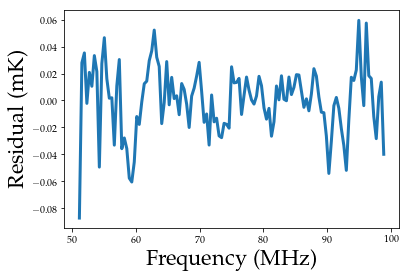

In [13]:
# I'll add optional arguments to keep c0 fixed when I need to do that later,
# and to include (co)variance in the data

def Tmodel_c1c2(c, nu, T, c0=None, data_ivar=None, data_UT=None, exponent=5):
    A = np.ones((len(nu), 6))
    A[:, 0] = 1/nu**2.5
    A[:, 1] = np.log(nu)/nu**2.5
    A[:, 2] = np.log(nu)**2/nu**2.5
    A[:, 3] = 1/nu**4.5
    A[:, 4] = 1/nu**2
    
    # Case where the exponent is fixed; get it from the arguments.
    if len(c) == 2:
        A[:, 5] = np.exp(-np.abs((nu - c[0])/c[1])**exponent)
    # Exponent floats.
    elif len(c) == 3:
        A[:, 5] = np.exp(-np.abs((nu - c[0])/c[1])**(c[2]**2))
    else:
        raise ValueError("Calling Tmodel_c1c2 with an incorrect number of fitting parameters.")
        
    result = Linmodel()
    
    # This is the case where c0 is free; we optimize over it.
    if c0 is None:
        Tfit = np.zeros(len(nu))
        b = T
    else:    # In case we want to hold c0 fixed
        Tfit = A[:, 5]*c0
        A = A[:, :5]
        b = T - Tfit
        
    if data_ivar is not None:
        if data_UT is None: # case of diagonal, 1-D variances
            Ap = A*np.sqrt(data_ivar[:, np.newaxis])
            bp = b*np.sqrt(data_ivar)
            result.cov_inv = np.dot(Ap.T, Ap)  # We need this for part 2c
        else:
            Ap = np.dot(data_UT, A)*np.sqrt(data_ivar)[:, np.newaxis]
            bp = np.dot(data_UT, b)*np.sqrt(data_ivar)
            # I could compute the covariance matrix for the parameters here, but I never use it.
    else:  # Unit variances
        Ap = A
        bp = b
        
    fit = np.linalg.lstsq(Ap, bp, rcond=None)[0]
    Tfit += np.dot(A, fit)

    result.y = Tfit
    result.par = fit
    return result

# This time the initial guess really matters!
# If you try something like [1, 1], it won't find the global minimum.
# I also have a much harder time getting it to converge if I use the 
# default minimization technique.

cguess = [1.05, 0.1]
cfit = optimize.minimize(chisq_model, cguess, (Tmodel_c1c2, nu, T), method="Powell").x
c1c2_result = Tmodel_c1c2(cfit, nu, T)
c0_best = c1c2_result.par[-1]
plt.plot(nu*75, T - c1c2_result.y)
plt.ylabel("Residual (mK)")
plt.xlabel("Frequency (MHz)")
print("The best-fit absorption peak is at %.1f MHz." % (cfit[0]*75))
print("The best-fit absorption depth is %.0f mK." % (1000*c0_best))
print("The scatter is %.1f mK." % (1000*np.std(T - c1c2_result.y)))

### Part 2b

I'll define one more helper function below that will save me a bit of code later.  This one is to compute the confidence intervals from a grid of parameter values and corresponding $\chi^2$ values.  I take the parameter value on the grid corresponding to the minimum $\chi^2$ and divide the domain into values above and below this.  That way the inverse function is defined on each half, and I can use interpolation to get the parameter value corresponding to $\chi^2 = \chi^2_{\rm min} + 1$.

In [6]:
def get_sig(x, chisq, x_best=None, chisq_best=None):
    # The best values of our parameter and of chi squared, if not provided
    if x_best is None:
        x_best = x[chisq == np.amin(chisq)]
    if chisq_best is None:
        chisq_best = np.amin(chisq)
        
    # We interpolate in chi squared. Separately in each half so that the inverse function exists.
    f_low = interpolate.interp1d(chisq[x <= x_best], x[x <= x_best], kind='cubic')
    sig_low = x_best - f_low(chisq_best + 1)
    f_high = interpolate.interp1d(chisq[x >= x_best], x[x >= x_best], kind='cubic')
    sig_high = f_high(chisq_best + 1) - x_best
    
    return [sig_low, sig_high]

Ok, now I can fit for my best parameters $c_1$ and $c_2$, use my best $c_0$ computed above, define an interval around $c_0$, and construct $\chi^2[c_0]$. I can then pass this to the function I defined above.

Best c1 = 1.043, best c2 = -0.1338, best c0 = -0.4991
The 1-sigma range for the depth is [-515.5, -482.8] mK
The formal significance is about 31 sigma.


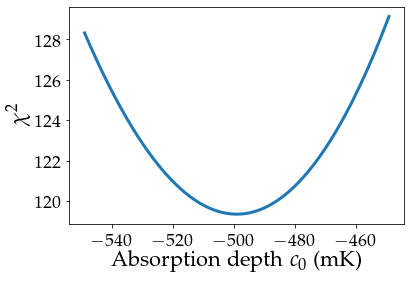

In [7]:
cfit = optimize.minimize(chisq_model, cguess, (Tmodel_c1c2, nu, T), method="Powell").x
chisq_best = chisq_model(cfit, Tmodel_c1c2, nu, T)/0.025**2
c1c2_result = Tmodel_c1c2(cfit, nu, T)
c0_best = c1c2_result.par[-1]
print("Best c1 = %.4g, best c2 = %.4g, best c0 = %.4g" % (cfit[0], cfit[1], c0_best))

# At each stage, optimize over parameters other than c0 and compute the best chi squared.

c0_vals = np.linspace(c0_best - 0.05, c0_best + 0.05, 201)
chisq_vals = np.zeros(c0_vals.shape)
for i in range(len(c0_vals)):
    cfit = optimize.minimize(chisq_model, cfit, (Tmodel_c1c2, nu, T, {'c0':c0_vals[i]}), method="Powell").x
    chisq_vals[i] = chisq_model(cfit, Tmodel_c1c2, nu, T, {'c0':c0_vals[i]})/0.025**2
   
plt.plot(c0_vals*1000, chisq_vals)
plt.xlabel(r"Absorption depth $c_0$ (mK)")
plt.ylabel(r"$\chi^2$")

sig_low, sig_high = get_sig(c0_vals, chisq_vals, c0_best, chisq_best)

print("The 1-sigma range for the depth is [%.1f, %.1f] mK" % 
      ((c0_best - sig_low)*1000, (c0_best + sig_high)*1000))
print("The formal significance is about %.0f sigma." % 
      (np.abs(2*c0_best/(sig_low + sig_high))))

### Part 2c

In this part we'll explicitly marginalize over all parameters _except_ for $c_0$.  This is a bit tricky.

The basic idea is the following.  At fixed values of $c_1$ and $c_2$, the likelihood is a multi-dimensional Gaussian fully described by the covariance matrix.  Marginalizing over all but $c_0$ is equivalent to multiplying by the square root of the determinant of the block of the inverse covariance matrix for the parameters other than $c_0$.  That's a bit of a mouthful; an example might help.

Take the following example:

${\cal L}(x,y) = \exp \left[ - \left( \frac{x^2 + y^2 + xy}{2} \right) \right]$

This is described by the inverse covariance matrix

${\bf C}^{-1} = \begin{bmatrix} 1 & \frac{1}{2} \\ \frac{1}{2} & 1 \end{bmatrix}$

and therefore by the covariance matrix

${\bf C} = \begin{bmatrix} \frac{4}{3} & -\frac{2}{3} \\ -\frac{2}{3} & \frac{4}{3} \end{bmatrix}$.

Integrating, or marginalizing, over $x$ means doing the integral

${\cal L}(y) = \int {\cal L}(x)\,dx = \int_{-\infty}^\infty \exp \left[ - \left( \frac{x^2 + y^2 + xy}{2} \right) \right] dx$

If I complete the square, I get

${\cal L}(y) = \int_{-\infty}^\infty \exp \left[ - \left( \frac{(x + y/2)^2 + 3/4y^2}{2} \right) \right] dx
= \sqrt{2\pi} \exp \left[ - \frac{3}{4} \frac{y^2}{2}\right]$

Up to the factor of $\sqrt{2\pi}$, this is the same as dividing by the determinant of the part of ${\bf C}^{-1}$ over which I am marginalizing.  I then end up with a Gaussian probability distribution described by the inverse of the part of the covariance matrix that I have left (not the part of ${\bf C}^{-1}$ corresponding to what I have left--be careful!).  In the case above, the relevant part of ${\bf C}^{-1}$ is just 1.  The covariance matrix describing what is left is just the single element $4/3$; inverse $3/4$.



In [8]:
# Let's establish the best-fit model and the best-fit chi squared.
c = optimize.minimize(chisq_model, cguess, (Tmodel_c1c2, nu, T), method="Powell").x
ivar = np.ones(T.shape)/0.025**2
result_best = Tmodel_c1c2(c, nu, T, c0=None, data_ivar=ivar)
chisq_best = np.sum((T - result_best.y)**2*ivar)

# To estimate how far I need to go in c1 and c2, I'll use same computation of 
# delta chisq = 1 that I used above, but in one variable at a time.  This won't
# give any kind of exact result but should produce a rough guess.

for sig_c1 in np.linspace(0, 0.1, 1000):
    chisq_high = chisq_model([c[0] + sig_c1, c[1]], Tmodel_c1c2, nu, T)/0.025**2
    if chisq_high > chisq_best + 1:
        break

for sig_c2 in np.linspace(0, 0.1, 1000):
    chisq_high = chisq_model([c[0], c[1] + sig_c2], Tmodel_c1c2, nu, T)/0.025**2
    if chisq_high > chisq_best + 1:
        break

for cov in np.linspace(0, 0.1, 1000):
    chisq_high = chisq_model([c[0] + cov/2**0.5, c[1] + cov/2**0.5], Tmodel_c1c2, nu, T)/0.025**2
    if chisq_high > chisq_best + 1:
        break

print("Rough sig_c1 = %.3g, rough sig_c2 = %.3g, rough cov = %.3g" % (sig_c1, sig_c2, cov))

Rough sig_c1 = 0.0013, rough sig_c2 = 0.0014, rough cov = 0.0013


Ok, so it looks like I should take pretty small steps.  Since the sigma along $c_1 + c_2$ is roughly the same as the sigma along either $c_1$ or $c_2$, it seems like the covariance matrix is pretty diagonal: the uncertainties are reasonably independent.  So I can freely step in both $c_1$ and $c_2$ without too much worry.

I'll do the integral with a simple Riemann sum.  The likelhood goes to zero pretty fast at the endpoints so a fancy, high-order algorithm will probably do no better.  The limits of integration here came from the estimate above: we go `nsig` sigma. These steps, as written, are $\sim$0.1$\sigma$ in both $c_1$ and $c_2$.  This is fairly 
expensive; it represents 40,000 steps and takes about 15 seconds on my laptop.  Compared to something like Markov Chain Monte Carlo, however, it is vastly faster (and more accurate!) because we have integrated over 6 out of 8 dimensions _analytically_.

Min and max c1 values within dchisq=50 of the peak: 1.03392, 1.05236
Limits of c1 integration: 1.03039, 1.05642
Min and max c2 values within dchisq=50 of the peak: -0.14290, -0.12416
Limits of c2 integration: -0.14782, -0.11980


Text(0.5, 0, 'Absorption depth $c_0$ (mK)')

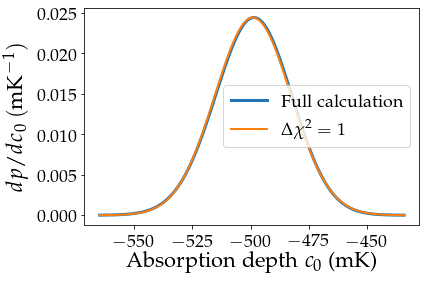

In [9]:
# We'll plot this over a range of c0 four times the dchisq=1 sigma.  
# The array like_c0 will hold the result.
c0_vals = np.linspace(c0_best - 4*sig_low, c0_best + 4*sig_high, 500)
like_c0 = np.zeros(c0_vals.shape)

# These will hold the minimum and maximum c1 and c2 that return a vaguely acceptable fit.
# We'll make sure that our intervals of integration extend past these on all sides.
# I'm setting these to be +/- infinity initially so that they will be set to the first 
# finite value in the loop.
min_c1, min_c2 = np.inf, np.inf
max_c1, max_c2 = -np.inf, -np.inf

nsig = 10  # How far to go away from the best c1, c2, in sigma
N = 200 # Number of steps in c1, c2

for dc1 in np.linspace(-nsig*sig_c1, nsig*sig_c1, N):
    for dc2 in np.linspace(-nsig*sig_c2, nsig*sig_c2, N):
        trial_c = [c[0] + dc1, c[1] + dc2]
        result = Tmodel_c1c2(trial_c, nu, T, c0=None, data_ivar=ivar)
        
        # We really just need the covariance matrix of this fit and the maximum 
        # chi squared to do the marginalization.
        chisq = np.sum((T - result.y)**2*ivar)
        
        # We want to make sure that our interval includes all c1 and c2 with
        # a chi squared within, say, ~7 sigma (d(chisq) = 50) of the best.
        # We'll check and see what the min and max values of c1 and c2 are that
        # satisfy this criterion, and make sure they aren't at our endpoints!
        if chisq < chisq_best + 50:   
            min_c1 = min(trial_c[0], min_c1)
            max_c1 = max(trial_c[0], max_c1)
            min_c2 = min(trial_c[1], min_c2)
            max_c2 = max(trial_c[1], max_c2)
        
        # The normalization  we need is the determinant of the inverse of the 
        # covariance matrix up to the last row and column.  
        # Check here that the matrix is not singular.  
        det_Cinv = np.linalg.det(result.cov_inv[:-1, :-1])
        if det_Cinv <= 0:
            print("Warning: singular covariance matrix for c1=%.3f, c2=%.3f, dchisq=%.1f" % 
                  (trial_c[0], trial_c[1], chisq - chisq_best))
            continue

        norm = np.exp(-chisq/2)/np.sqrt(det_Cinv)
        
        # And the variance on this particular measurement of c0 is given by the 
        # relevant part of the covariance matrix.  I'll use the pseudo-inverse
        # to prevent a singular matrix error in case the uncertainty is formally
        # zero.  This can happen if the fit is very, very poor.
        c0 = result.par[-1]
        cov = np.linalg.pinv(result.cov_inv)
        var_c0 = cov[-1, -1]
        
        # If we do happen to get a singular covariance matrix here, it probably 
        # means that the fit was garbage (var -> 0 for chisq -> infinity)
        if var_c0 == 0:
            if chisq < chisq_best + 50:
                # If the fit wasn't garbage, this is surprising--check for this!
                print("Unexpectedly singular covariance matrix in an apparently reasonable fit!")
            continue
        
        # This is the full marginalized likelihood at these values of c1 and c2.
        like_c0 += norm*np.exp(-(c0_vals - c0)**2/(2*var_c0))
        
print("Min and max c1 values within dchisq=50 of the peak: %.5f, %.5f" % (min_c1, max_c1))
print("Limits of c1 integration: %.5f, %.5f" % (c[0] - nsig*sig_c1, c[0] + nsig*sig_c1))
print("Min and max c2 values within dchisq=50 of the peak: %.5f, %.5f" % (min_c2, max_c2))
print("Limits of c2 integration: %.5f, %.5f" % (c[1] - nsig*sig_c2, c[1] + nsig*sig_c2))

# Now plot it up!
like_c0 = like_c0/(np.sum(like_c0)*(c0_vals[1] - c0_vals[0]))
plt.plot(c0_vals*1000, like_c0/1000)     # change units to mK

# We'll compare this to what we had before
var_c0_dchisq1 = ((sig_low + sig_high)/2)**2
like_dchisq1 = np.exp(-(c0_vals - c0_best)**2/(2*var_c0_dchisq1))
like_dchisq1 /= np.sqrt(2*np.pi*var_c0_dchisq1)
plt.plot(c0_vals*1000, like_dchisq1/1000, linewidth=2)
plt.legend(["Full calculation", r"$\Delta \chi^2 = 1$"])
plt.ylabel(r"$dp/dc_0~({\rm mK}^{-1})$")
plt.xlabel(r"Absorption depth $c_0$ (mK)")

Ok, everything checked out, and we got essentially the exact same answer from the $\Delta \chi^2 = 1$ simplistic calculation from earlier.  I just managed to stay away from the endpoints with a threshold of $\chi^2 = \chi^2_{\rm min} + 50$.  It looks like we are at a sharp peak of the likelihood function where, under all of our assumptions, things are accurately Gaussian.  This is very different from the second problem of Homework 1, where the peak was not accurately Gaussian at all.

### Part 3a

First, I will define a 2D array of the difference in frequencies between each pair of measurements.  This will have dimension $n \times n$, where $n$ is the number of frequencies.  Then I'll implement the given covariance formula

$A \delta_{ij} + B \cos \left[ \frac{0.3}{\rm MHz} \left(\nu_1 - \nu_2 \right) \right] \exp \left[ -\big| \frac{\nu_1 - \nu_2}{60\,{\rm MHz}} \big| \right]$

In [10]:
nu_x, nu_y = np.meshgrid(nu, nu)
delta_nu_MHz = (nu_x - nu_y)*75
A = 0.025**2
B = 2*A
covar = np.identity(len(nu))*A
covar += B*np.cos(0.3*delta_nu_MHz)*np.exp(-np.abs(delta_nu_MHz)/60)
Cdata_inv = np.linalg.inv(covar)

### Part 3b

Here I'll use some of those extra options I added to `Tmodel_c1c2`.  I'll first diagonalize the covariance matrix, and then feed in the results to the model fit.  I'll defer the fitting of Equation (1) + Equation (4) to Parts c and d below, since it fits nicely there.

In [11]:
Udata, Wdata, UTdata = np.linalg.svd(covar)
ivar_diagonalized = 1/Wdata
ivar_diagonalized[Wdata < np.amax(Wdata)*1e-14] = 0

# Use c0=0 to disable the fitting of this extra component.
result = Tmodel_c1c2(c, nu, T, c0=0, data_ivar=ivar_diagonalized, data_UT=UTdata)
result_diag = Tmodel_c1c2(c, nu, T, c0=0)

chisq_diag = np.sum((result_diag.y - T)**2/0.025**2)
chisq = np.linalg.multi_dot([result.y - T, Cdata_inv, result.y - T])

print("The chi squared value with the diagonal covariance matrix is %.1f." % (chisq_diag))
print("The chi squared value with this new covariance matrix is %.1f." % (chisq))

The chi squared value with the diagonal covariance matrix is 1511.2.
The chi squared value with this new covariance matrix is 199.8.


### Parts 3c and 3d

I'll consider the fit with the addition of Equation (4) here, since it fits a bit better.  This time we fully confront the nightmare of local minima.  I'll try to list out every set of parameters within 5 formal sigma ($\delta \chi^2 = 25$) of the global best fit.  I'll first define a helper function to find these local minima for me.  This will be stochastic, kind of like basin hopping.  I'll put in the mean and standard deviation of the guesses to take in $c_1$, $c_2$, and (if desired) the exponent.  I'll then try to find the unique minima by looking for ones that differ by at least 0.02 in $c_1$ and/or $c_2$ from minima already identified.

In [12]:
def find_local_minima(c_mean, c_std, nu, T, extra_args, n=100, dchisq_thresh=25):
    minima_found = []
    params = []

    for i in range(n):
        
        # Define my guess for the parameters here, then optimize.
        cguess = 1.*np.asarray(c_mean)
        cguess += np.random.randn(len(cguess))*np.asarray(c_std)

        cfit = optimize.minimize(chisq_model, cguess, (Tmodel_c1c2, nu, T, extra_args), method="Powell").x
        chisq_best_covar = chisq_model(cfit, Tmodel_c1c2, nu, T, extra_args)

        # Also fetch the best-fit c0 at these parameters.
        result = Tmodel_c1c2(cfit, nu, T, data_ivar=extra_args['data_ivar'], 
                             data_UT=extra_args['data_UT'], exponent=extra_args['exponent'])
        c0_best_covar = result.par[-1]
        
        cfit = np.abs(cfit)  # c2 and sqrt(exponent) don't care about the sign. 
        # Note that I am *not* taking the absolute value of c0.
        
        # Try to keep only unique minima.  
        if i > 0:  # Always keep the first minimum we find, then check for duplicates.
            diff_par = np.sum((cfit[np.newaxis, :] - np.asarray(params)[:, :-1])**2, axis=1)
        # The sum of the squared differences in parameters must be at least 0.02**2 with every previous minimum.
        # The value 0.02**2 is a bit of a hack and will not generalize to other applications.
        if i == 0 or np.amin(diff_par) > 0.02**2: 
            minima_found += [chisq_best_covar]
            params += [list(cfit) + [c0_best_covar]]
        
    # Now what minima did we find?  Sort by chi squared and return two lists.
    isort = np.argsort(np.asarray(minima_found))
    global_best_chisq = np.amin(minima_found)
    minlist = []
    parlist = []
    for i in isort:
        if minima_found[i] < global_best_chisq + dchisq_thresh:
            minlist += [minima_found[i]]
            parlist += [params[i]]
            
    return minlist, parlist

In [13]:
n = 100  # Number of trial starting points

# For the case of exponent of 5:

extra_args = {'data_ivar':ivar_diagonalized, 'data_UT':UTdata, 
                      'Cdata_inv':Cdata_inv, 'exponent':5}
chisq_minima, parameters = find_local_minima([1, 0], [0.2, 0.2], nu, T, extra_args, n=n)
print("We found the following minima for an exponent of 5:")
print("%13s"*4 % ("chisq", "c_1", "c_2", "c_0"))
for i in range(len(chisq_minima)):
    parameters[i][1] = np.abs(parameters[i][1])   # Want absolute value here
    print(' %12.4g'*(len(parameters[0]) + 1) % (chisq_minima[i], *parameters[i]))

# For the case of exponent of 2:

extra_args['exponent'] = 2
chisq_minima, parameters = find_local_minima([1, 0], [0.2, 0.2], nu, T, extra_args, n=n)
print("We found the following minima for an exponent of %.1f:" % (extra_args['exponent']))
print("%13s"*4 % ("chisq", "c_1", "c_2", "c_0"))
for i in range(len(chisq_minima)):
    parameters[i][1] = np.abs(parameters[i][1])   # Want absolute value here
    print(' %12.4g'*(len(parameters[0]) + 1) % (chisq_minima[i], *parameters[i]))
    
# For the case of a floating exponent:

chisq_minima, parameters = find_local_minima([1, 0, 5**0.5], [0.2, 0.2, 0.5], nu, T, extra_args, n=n)
print("We found the following minima for a floating exponent:")
print("%13s"*5 % ("chisq", "c_1", "c_2", "exponent", "c_0"))
for i in range(len(chisq_minima)):
    parameters[i][1] = np.abs(parameters[i][1])   # Want absolute value here
    parameters[i][2] = parameters[i][2]**2   # Squared value is the exponent
    print(' %12.4g'*(len(parameters[0]) + 1) % (chisq_minima[i], *parameters[i]))
    
# And just for reference, for an exponent of 5 and a diagonal covariance matrix:

extra_args = {'data_ivar':ivar, 'data_UT':None, 'Cdata_inv':np.diag(ivar), 'exponent':5}
chisq_minima, parameters = find_local_minima([1, 0], [0.2, 0.2], nu, T, extra_args, n=n, dchisq_thresh=200)
print("We found the following minima for an exponent of 5 and a diagonal covariance matrix:")
print("%13s"*4 % ("chisq", "c_1", "c_2", "c_0"))
for i in range(len(chisq_minima)):
    parameters[i][1] = np.abs(parameters[i][1])   # Want absolute value here
    print(' %12.4g'*(len(parameters[0]) + 1) % (chisq_minima[i], *parameters[i]))


We found the following minima for an exponent of 5:
        chisq          c_1          c_2          c_0
        88.92        1.041       0.1323      -0.4703
        100.7       0.7493       0.1773        1.048
We found the following minima for an exponent of 2.0:
        chisq          c_1          c_2          c_0
        109.1       0.8609       0.0841       0.7346
          116       0.9576      0.06343      -0.4109
We found the following minima for a floating exponent:
        chisq          c_1          c_2     exponent          c_0
        86.61        1.041       0.1328        4.223      -0.5653
        98.33        0.777       0.1504        3.998        1.145
        101.3       0.7346       0.1916        5.258        1.089
        101.6       0.7244       0.2017        5.553        1.085
        102.3       0.9552        2.613        2.197         3357
        102.5       0.6636       0.2615        7.217        1.083
        102.7       0.6458       0.2791        7.695       

Oh good lord!  For the original case, at the bottom, one minimum is much, much deeper than the others (and that is what got the paper into *Nature*).  It's still not $30\sigma$--there is another minimum with $\chi^2 \approx \chi^2_{\rm min} + 154$, equivalent to about $12.4\sigma$.  But what if my estimated covariance matrix is closer to a real description of the data than the adopted diagonal covariance matrix?  Then it's a mess.  With an exponent fixed at 5 I still have a nice local minimum at the same frequency and almost the same absorption depth ($c_0$) as before.  But it's not as deep a minimum in $\chi^2$.  I'll compute a formal standard deviation below using $\Delta \chi^2 = 1$.  But this is meaningless when I go more than three standard deviations ($\Delta \chi^2 \approx 9$) away.  At that $\Delta \chi^2$, there is _another_ minimum, but this one is at about 56 MHz and shows up in *emission*, which is unphysical.  If I have a floating exponent then the landscape of local minima just gets ridiculous.  And if I fix the exponent at a more physically realistic value of 2, then the best-fit is actually in emission.

Onward to the case of an exponent of 5 with the full covariance matrix.  The others would be done in the same way.

The 1-sigma range for the depth is [-515.8, -425.0] mK
The formal significance is about 10 sigma.


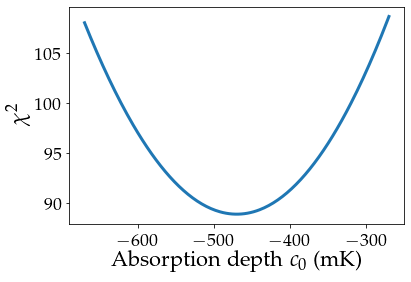

In [14]:
extra_args = {'data_ivar':ivar_diagonalized, 'data_UT':UTdata, 
              'Cdata_inv':Cdata_inv, 'exponent':5}
cguess = [1.04, 0.13]
cfit = optimize.minimize(chisq_model, cguess, (Tmodel_c1c2, nu, T, extra_args), method="Powell").x
result = Tmodel_c1c2(cfit, nu, T, data_ivar=extra_args['data_ivar'], 
                     data_UT=extra_args['data_UT'], exponent=extra_args['exponent'])

chisq_best_covar = chisq_model(cfit, Tmodel_c1c2, nu, T, extra_args)
c0_best_covar = result.par[-1]

# This looks basically the same as what we did before.
# Make an array of c0 values, then compute the best-fit chi squared at each one,
# then plot it up.

c0_vals = np.linspace(c0_best_covar - 0.2, c0_best_covar + 0.2, 201)
chisq_vals = np.zeros(c0_vals.shape)

for i in range(len(c0_vals)):
    extra_args['c0'] = c0_vals[i]
    cfit = optimize.minimize(chisq_model, cfit, (Tmodel_c1c2, nu, T, extra_args), method="Powell").x
    chisq_vals[i] = chisq_model(cfit, Tmodel_c1c2, nu, T, extra_args)
    
# Plot up chi squared

plt.plot(c0_vals*1000, chisq_vals)
plt.xlabel(r"Absorption depth $c_0$ (mK)")
plt.ylabel(r"$\chi^2$")

sig_low, sig_high = get_sig(c0_vals, chisq_vals, c0_best_covar, chisq_best_covar)

print("The 1-sigma range for the depth is [%.1f, %.1f] mK" % 
      ((c0_best_covar - sig_low)*1000, (c0_best_covar + sig_high)*1000))
print("The formal significance is about %.0f sigma." % 
      (np.abs(2*c0_best_covar/(sig_low + sig_high))))

$\ldots$ but note that there is another minimum way over to the right at $c_0 = +1050$ mK and $\chi^2 = 100.7$!  This looks like a parabola locally, but it turns back over.  It most certainly is not a $10\,\sigma$ detection.

I'll make a plot of $\chi^2$ for the case of an exponent of 2 just for fun.  This isn't marginalized over the other parameters, but takes their best value at a given $c_0$.  This means that well-separated minima in the high-dimensional space can induce discontinuities here.  Of course, I'm assuming I got the projection right, and there is no guarantee of that (I checked as best I could).  There are two local minima, but neither should probably be taken too seriously.  Especially the better minimum, which is completely unphysical if interpreted as a signal from the early universe.

Text(0, 0.5, '$\\chi^2$')

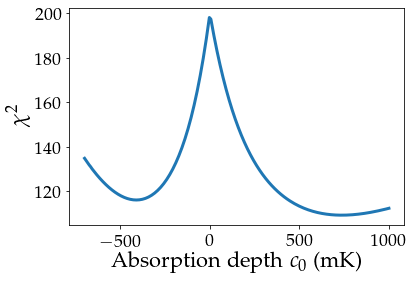

In [15]:
extra_args = {'data_ivar':ivar_diagonalized, 'data_UT':UTdata, 
              'Cdata_inv':Cdata_inv, 'exponent':2}

c0_vals = np.linspace(-0.7, 1, 201)
chisq_vals = np.zeros(c0_vals.shape)

for i in range(len(c0_vals)):
    extra_args['c0'] = c0_vals[i]
    if c0_vals[i] > 0:
        cfit = [0.86, 0.08]
    else:
        cfit = [0.96, 0.08]
    cfit = optimize.minimize(chisq_model, cfit, (Tmodel_c1c2, nu, T, extra_args), method="Powell").x
    chisq_vals[i] = chisq_model(cfit, Tmodel_c1c2, nu, T, extra_args)
    
# Plot up chi squared

plt.plot(c0_vals*1000, chisq_vals)
plt.xlabel(r"Absorption depth $c_0$ (mK)")
plt.ylabel(r"$\chi^2$")